# Introductory examples for building machine learning models

##### Nikolas Fechner
##### Novartis Institutes for BioMedical Research, Novartis Campus, 4002 Basel, Switzerland

This notebook contains some examples based on toy data that aim to demonstrate some of the concept and pitfalls in building machine learning models.

Using toy data has the advantage that the true function is know and it can be assessed which model actually is best in reconstructing it.

The function that we are trying to reconstruct is: $\bf{f: x \rightarrow x \cdot sin(\frac{1}{10} \cdot x^2)+x}$

But as usual in machine learning we only have access to a few example points $(x,f(x))$ that are also subject to a Gaussian noise $\epsilon$.

In [1]:
%pylab inline

import seaborn as sns
sns.set_context(rc={'lines.markeredgewidth': 1.0})
import numpy as np

np.random.seed = 42

def fu(x):
    '''The true function that we try to reconstruct'''
    y = x*np.sin(0.1*x*x)+x
    return y

def noisy(f,x, sigma):
    '''A noisy version of the true function'''
    return  fu(x) + np.random.normal(0, sigma)

Populating the interactive namespace from numpy and matplotlib


Our data domain is defined as $[0,10]$ and the training set $X$ will consists of 20 equidistant points from that domain. The training observations $Y$ are evaluations of the function $f$ at the elements of X, with $\cal{N}(0,2)$-distributed noise added

In [2]:
domain = np.arange(0,10,0.01).reshape(1000,1)
X = np.arange(0,10,0.5)
X = X.reshape(len(X),1).tolist()
Y = [noisy(fu,x[0],2.0) for x in X]

First, let's have a look on the raw data. The green line show the true function, the red dots the data points that we can use for building a model.

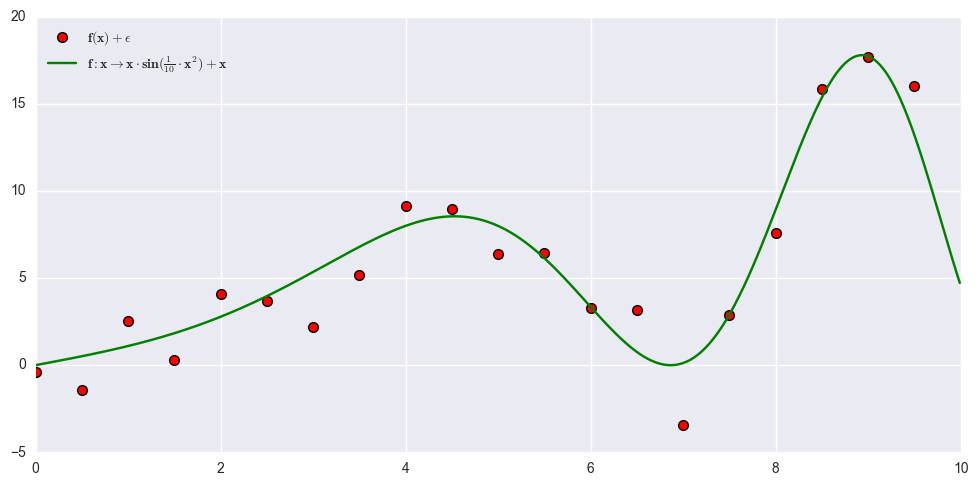

In [3]:

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])

ax.plot(X,Y,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(domain,[fu(_) for _ in domain],color="green", label='$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
leg = ax.legend(loc='upper left')

For this examples, I am only going to use Gaussian process regression - mainly because the theory behind it allows non-linear models and well-defined control of regularization.

The Gaussian process offers a couple of parameters in scikit-learn [http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcess.html], but here we use only two as non-defaults.

1. The covariance function will always be set to 'cubic', because this is closer to the known true function
2. The 'nugget' will be the parameter to control the regularization. It can be seen as a measure for the accepted deviation from the training observations

In [4]:
from sklearn import gaussian_process

### Fitting data

In the first example a very small nugget is used to fit the training data very accurately. This can be seen in the chart by looking how precisely every single training sample is predicted - unfortunately including all the added noise.

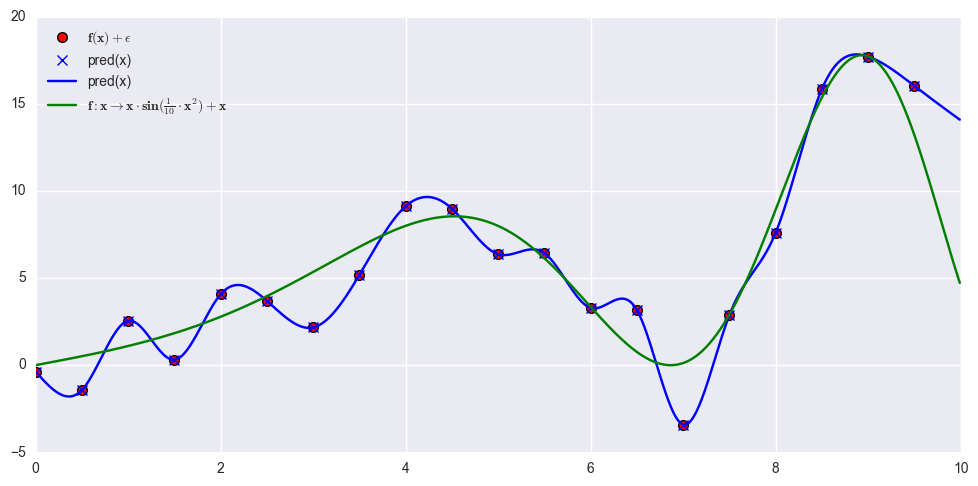

In [5]:

GP = gaussian_process.GaussianProcess(nugget=0.0000000000001,corr='cubic')
GP.fit(X,Y)
pY = GP.predict(domain)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])
ax.plot(X,Y,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(X,GP.predict(X),"x",color="blue", label = 'pred(x)')
ax.plot(domain,pY,color="blue", label = 'pred(x)')



ax.plot(domain,[fu(_) for _ in domain],color="green", label='$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
leg = ax.legend(loc='upper left')

While the fitting of the noise seems to be not a big problem because the deviation from the tru function is not too extrem, the consequence of this $\bf overfitting$ becomes clearer when extending the x-range to include a bit of extrapolation. 

Here is become clear that the increased complexity contributes to a rapid deterioration from the y-range as soon as the x-domain is left. 

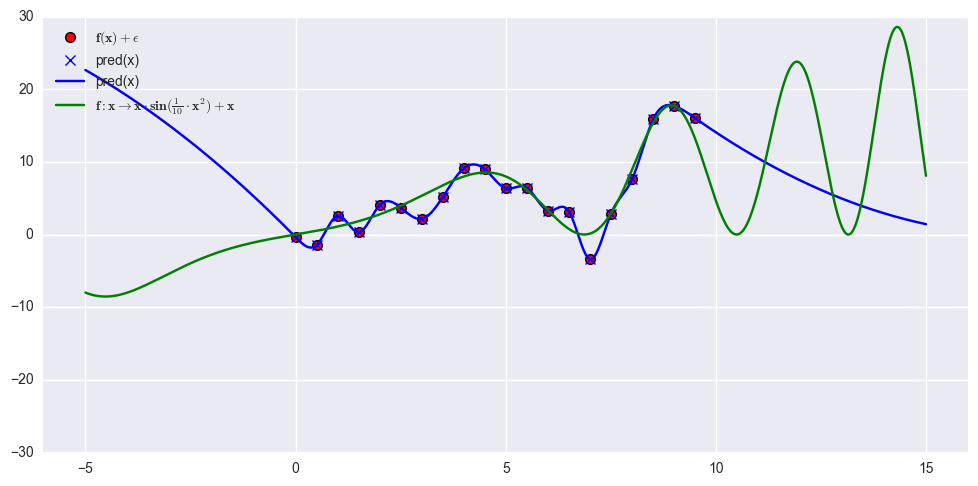

In [6]:
ext_domain = np.arange(-5,15,0.01).reshape(2000,1)

GP = gaussian_process.GaussianProcess(nugget=0.0000000000001,corr='cubic')
GP.fit(X,Y)
pY = GP.predict(ext_domain)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([-6.0, 16.0])
ax.set_ylim([-30.0, 30.0])
ax.plot(X,Y,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(X,GP.predict(X),"x",color="blue", label = 'pred(x)')
ax.plot(ext_domain,pY,color="blue", label = 'pred(x)')



ax.plot(ext_domain,[fu(_) for _ in ext_domain],color="green", label='$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
leg = ax.legend(loc='upper left')

On way to control overfitting is to ensure that the complexity of of the model is limited. Two common ways to achieve this is to limit the singular contributions of specific feature dimensions or specific data points.

In this example, this idea is demonstrated by increasing the nugget parameter. This has the effect that the training process is allowed a looser fit of the training data points, hence allowing for a less complex prediction function as it can be seen here. In contrast to the previous case, almost none data point is reproduced exactly, however, the true function is reconstructured generally better than before, because a lot of the local variance of the training data was due to the added noise.

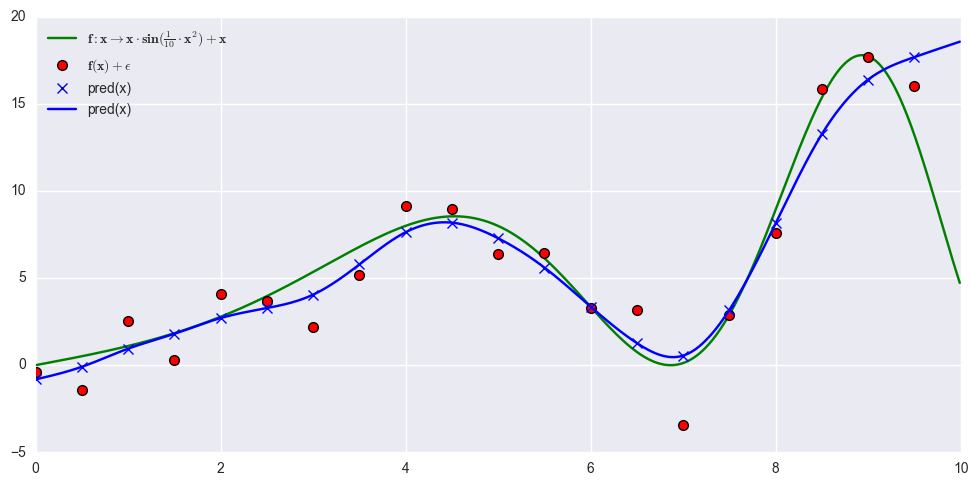

In [7]:
GP = gaussian_process.GaussianProcess(nugget=0.0001,corr='cubic')
GP.fit(X,Y)
pY = GP.predict(domain)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])

ax.plot(domain,[fu(_) for _ in domain],color="green", label = '$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
ax.plot(X,Y,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(X,GP.predict(X),"x",color="blue", label = 'pred(x)')
ax.plot(domain,pY,color="blue", label = 'pred(x)')
leg = ax.legend(loc='upper left')

This stronger egularization also helps with the extrapolation to some degree (true extrapolation is generally very hard to achieve) and the models prediction at least deteriorate not as fast as in the earlier example.

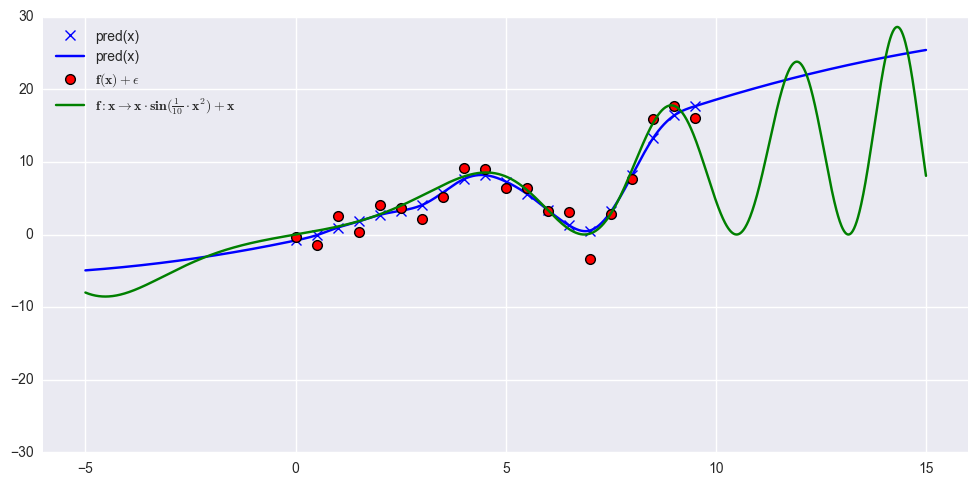

In [8]:
ext_domain = np.arange(-5,15,0.01).reshape(2000,1)

GP = gaussian_process.GaussianProcess(nugget=0.0001,corr='cubic')
GP.fit(X,Y)
pY = GP.predict(ext_domain)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([-6.0, 16.0])
ax.set_ylim([-30.0, 30.0])

ax.plot(X,GP.predict(X),"x",color="blue", label = 'pred(x)')
ax.plot(ext_domain,pY,color="blue", label = 'pred(x)')


ax.plot(X,Y,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(ext_domain,[fu(_) for _ in ext_domain],color="green", label='$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
leg = ax.legend(loc='upper left')

### Interpolation

For the next examples a middle part of the data points are removed from the training set to see how the different parameterization handlethe gap in the data.

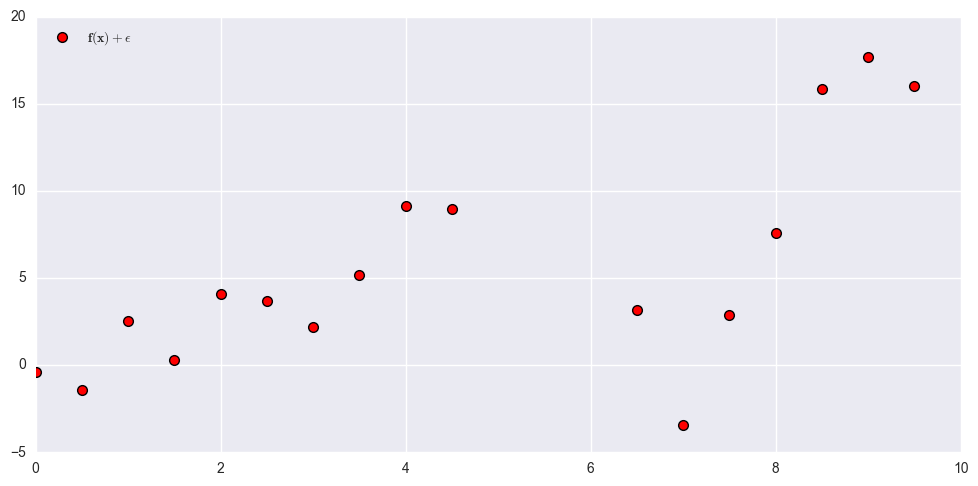

In [9]:
tX = [_ for _ in X if _[0] < 5 or _[0] > 6]
tY = [Y[i] for i in range(len(Y)) if X[i][0] < 5 or X[i][0] > 6]

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])

ax.plot(tX,tY,'o',color="red", label = '$\\bf{f(x)+\epsilon}$')
leg = ax.legend(loc='upper left')

As before, the small-nugget variant tends to overshoot occasionally and has a higher local variance.

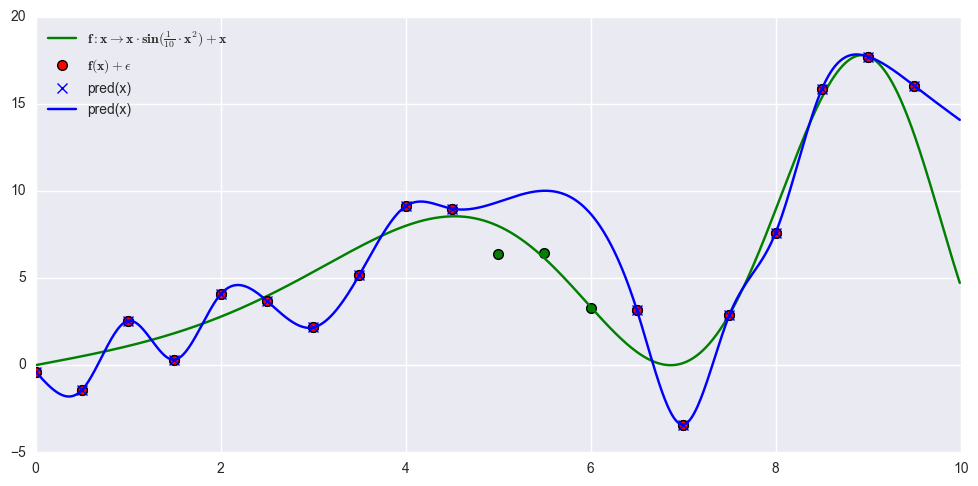

In [10]:
GP = gaussian_process.GaussianProcess(nugget=0.0000000000001,corr='cubic')
GP.fit(tX,tY)
pY = GP.predict(domain)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])

ax.plot(X,Y,"o",color="green")
ax.plot(domain,[fu(_) for _ in domain],color="green", label = '$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
ax.plot(tX,tY,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(tX,GP.predict(tX),"x",color="blue", label = 'pred(x)')
ax.plot(domain,pY,color="blue", label = 'pred(x)')
leg = ax.legend(loc='upper left')

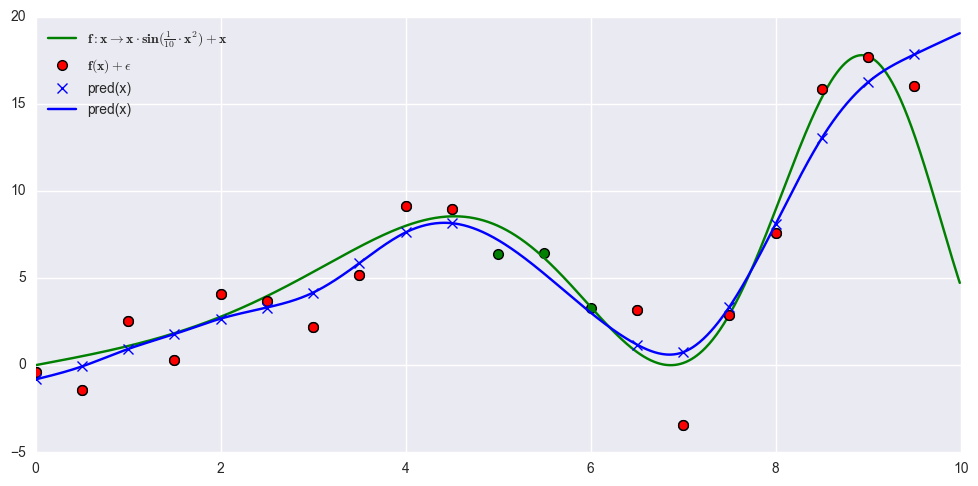

In [11]:
GP = gaussian_process.GaussianProcess(corr='cubic',nugget=0.0001)
GP.fit(tX,tY)
pY = GP.predict(domain)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])

ax.plot(X,Y,"o",color="green")
ax.plot(domain,[fu(_) for _ in domain],color="green", label = '$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
ax.plot(tX,tY,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(tX,GP.predict(tX),"x",color="blue", label = 'pred(x)')
ax.plot(domain,pY,color="blue", label = 'pred(x)')
leg = ax.legend(loc='upper left')

The theory  behind Gaussian processes allows to compute a predictive standard deviation. The following charts are based on the example from the scikit-learn website [http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gp_regression.html#example-gaussian-process-plot-gp-regression-py].

Here it can be seen, that a more complex model fits the data more closely and is apparently also more confident within the domain as indicated by the fairly small 95% confidence intervals. However, the true function (green line) actually lies frequently outside the confidence interval.

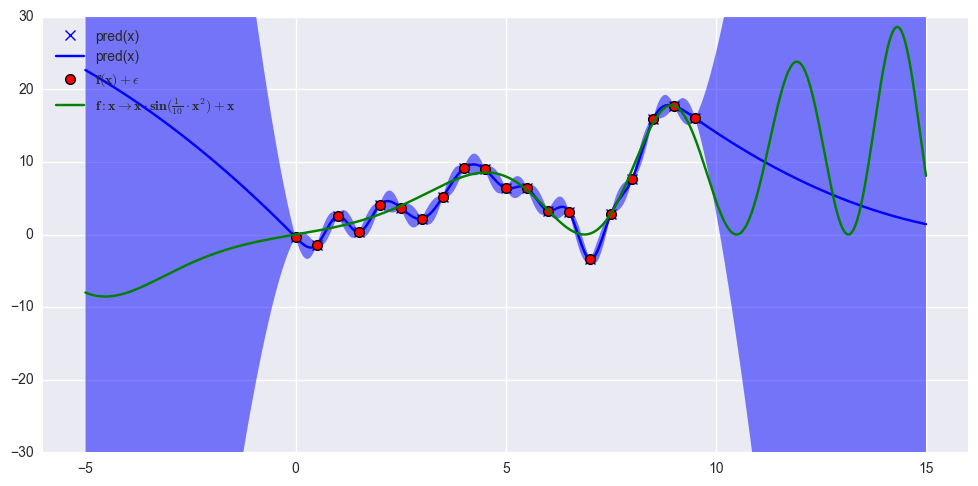

In [12]:
ext_domain = np.arange(-5,15,0.01).reshape(2000,1)

GP = gaussian_process.GaussianProcess(nugget=0.0000000000001,corr='cubic')
GP.fit(X,Y)
pY, MSE = GP.predict(ext_domain, eval_MSE=True)
sigma = np.sqrt(MSE)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([-6.0, 16.0])
ax.set_ylim([-30.0, 30.0])

ax.plot(X,GP.predict(X),"x",color="blue", label = 'pred(x)')
ax.plot(ext_domain,pY,color="blue", label = 'pred(x)')


ax.plot(X,Y,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(ext_domain,[fu(_) for _ in ext_domain],color="green", label='$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
leg = ax.legend(loc='upper left')


# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
ax.fill(np.concatenate([ext_domain, ext_domain[::-1]]),
        np.concatenate([pY - 1.9600 * sigma,
                       (pY + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')



The less complex model is generally less confident about every prediction, but the true function lies always inside the 95% confidence interval.

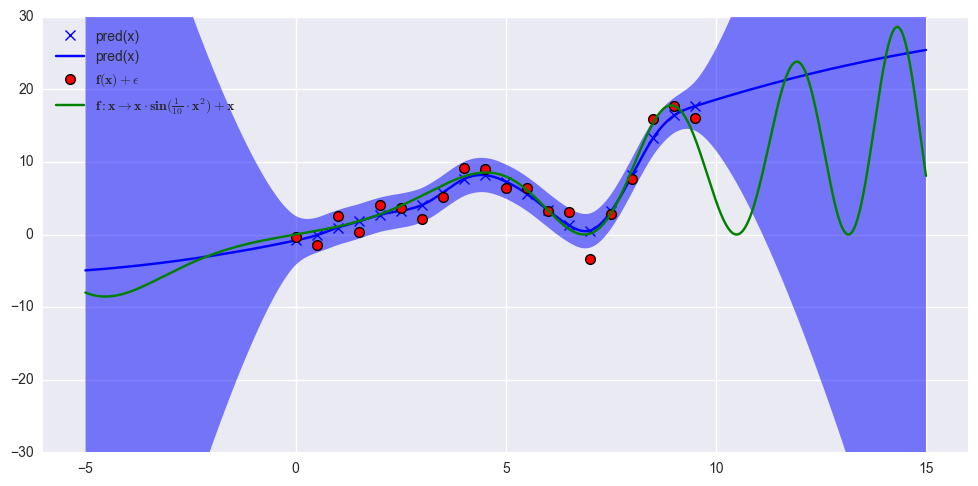

In [13]:
ext_domain = np.arange(-5,15,0.01).reshape(2000,1)

GP = gaussian_process.GaussianProcess(nugget=0.0001,corr='cubic')
GP.fit(X,Y)
pY, MSE = GP.predict(ext_domain, eval_MSE=True)
sigma = np.sqrt(MSE)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([-6.0, 16.0])
ax.set_ylim([-30.0, 30.0])

ax.plot(X,GP.predict(X),"x",color="blue", label = 'pred(x)')
ax.plot(ext_domain,pY,color="blue", label = 'pred(x)')


ax.plot(X,Y,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(ext_domain,[fu(_) for _ in ext_domain],color="green", label='$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
leg = ax.legend(loc='upper left')


# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
ax.fill(np.concatenate([ext_domain, ext_domain[::-1]]),
        np.concatenate([pY - 1.9600 * sigma,
                       (pY + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')



This increased robustness of the less complex model is also advantageous for the interpolation case, because not only the predictions itself, but also the confidence regions do not deteriote as quickly, which allows for a more reliable estimate of the interpolated region.

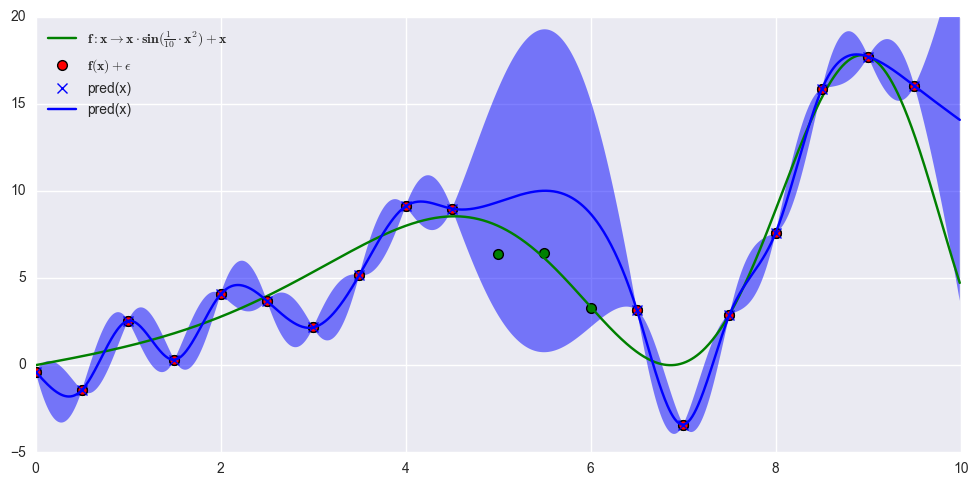

In [14]:
ext_domain = np.arange(-5,15,0.01).reshape(2000,1)

GP = gaussian_process.GaussianProcess(nugget=0.0000000000001,corr='cubic')
GP.fit(tX,tY)
pY, MSE = GP.predict(domain, eval_MSE=True)
sigma = np.sqrt(MSE)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])

ax.plot(X,Y,"o",color="green")
ax.plot(domain,[fu(_) for _ in domain],color="green", label = '$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
ax.plot(tX,tY,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(tX,GP.predict(tX),"x",color="blue", label = 'pred(x)')
ax.plot(domain,pY,color="blue", label = 'pred(x)')
leg = ax.legend(loc='upper left')


# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
ax.fill(np.concatenate([domain, domain[::-1]]),
        np.concatenate([pY - 1.9600 * sigma,
                       (pY + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')



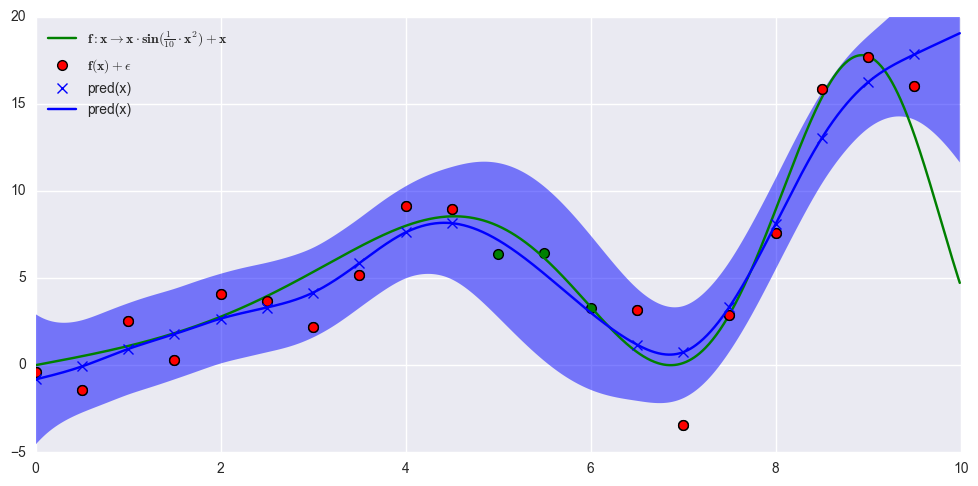

In [15]:
ext_domain = np.arange(-5,15,0.01).reshape(2000,1)

GP = gaussian_process.GaussianProcess(nugget=0.0001,corr='cubic')
GP.fit(tX,tY)
pY, MSE = GP.predict(domain, eval_MSE=True)
sigma = np.sqrt(MSE)

figure,ax= pyplot.subplots(1,1)
figure.set_size_inches(10,5)
figure.tight_layout()

ax.set_xlim([0.0, 10.0])
ax.set_ylim([-5.0, 20.0])

ax.plot(X,Y,"o",color="green")
ax.plot(domain,[fu(_) for _ in domain],color="green", label = '$\\bf{f: x \\rightarrow x \\cdot sin(\\frac{1}{10} \\cdot x^2)+x}$')
ax.plot(tX,tY,"o",color="red", label = '$\\bf{f(x)+\epsilon}$')
ax.plot(tX,GP.predict(tX),"x",color="blue", label = 'pred(x)')
ax.plot(domain,pY,color="blue", label = 'pred(x)')
leg = ax.legend(loc='upper left')


# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
ax.fill(np.concatenate([domain, domain[::-1]]),
        np.concatenate([pY - 1.9600 * sigma,
                       (pY + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')

